This Notebook is for displaying results reproduced from TargetFinder using their data and suggested code on [Github](https://github.com/shwhalen/targetfinder)

We also added some other validation methods other than shuffling the data.

Shuffling the data creates highly overlapping testing and training data, which results in over-optimistic estimation of the performance.

In [2]:
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone
import os,sys
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.externals.joblib import Parallel, delayed
os.chdir("targetfinder-master/")
%matplotlib inline
import numpy as np
np.random.seed(0)
nonpredictors = ['enhancer_chrom', 'enhancer_start', 'enhancer_end', 'window_name',
                     'promoter_chrom', 'promoter_start', 'promoter_end', 
                     'window_chrom', 'window_start', 'window_end',
                     'active_promoters_in_window', 'interactions_in_window', 
                     'enhancer_distance_to_promoter', 'bin', 'label']

colors =  [
    (214, 39, 40), (255, 152, 150),    #redish
    (31, 119, 180), (174, 199, 232),   #blueish           
    (44, 160, 44), (152, 223, 138), #greenish
    (148, 103, 189), (197, 176, 213), #purple
    (255, 127, 14), (255, 187, 120),   #orangish
    (140, 86, 75), (196, 156, 148),    #brown
    (227, 119, 194), (247, 182, 210), #pink
    (127, 127, 127), (199, 199, 199),    #grey
    (188, 189, 34), (219, 219, 141),   #dark green
    (23, 190, 207), (158, 218, 229)  #bright blue
]
for i in range(len(colors)):
    colors[i] = (colors[i][0]/255., colors[i][1]/255., colors[i][2]/255.)
from itertools import combinations
from sklearn.utils import shuffle

In [3]:
import sklearn
from sklearn.metrics import mean_absolute_error
sklearn.__version__

'0.18.1'

In [4]:
inch = 25.4
col1Width = 87 / inch

In [4]:
def load_data(cell):
    

    print(cell)
    training_df = pd.read_hdf('{}/output-epw/training.h5'.format(cell), 
                              'training').set_index(['enhancer_name', 'promoter_name'])
    
    chrom_pos_counts = defaultdict(int)
    chrom_neg_counts = defaultdict(int)
    for x in training_df.index:
        temp = x[0].split(":")[0] + ':'
        if training_df.ix[x, 'label'] == 1:
            chrom_pos_counts[temp] += 1
        else:
            chrom_neg_counts[temp] += 1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    map_to_int = {}
    for c in chrom_neg_counts.keys():
        print(c)
        try:
            a = int(c.strip(':').split('|')[1].strip('chr'))
            map_to_int[c] = a
        except:
            map_to_int[c] = ord(c.strip(':').split('|')[1].strip('chr'))
    chroms = sorted(list(chrom_pos_counts.keys()), key=lambda k:map_to_int[k])
    ax.plot([chrom_pos_counts[x] for x in chroms], "o", linewidth=0, label="pos_count")
    ax.plot([chrom_neg_counts[x] for x in chroms], "x", linewidth=0, label="neg_count")
    ax.set_xlim([-1, len(chroms)])
    ax.set_xticks(range(len(chroms)))
    ax.set_xticklabels(chroms, rotation=90)

    ax2 = ax.twinx()
    ax2.plot([chrom_neg_counts[x]*1.0 / chrom_pos_counts[x] for x in chroms], '^r', linewidth=0, label="ratio")

    ax2.set_ylabel('neg/pos ratio', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    ax.legend(loc="upper left")
    ax2.legend(loc="upper center")
    plt.show()
    
    predictors_df = training_df.drop(nonpredictors, axis = 1)
    labels = training_df['label']
    return predictors_df, labels, chrom_pos_counts, chrom_neg_counts

def get_random_score(predictors_df, labels):

    cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)
    tasks = []
    for train_idx, test_idx in cv.split(predictors_df, labels):
        train_data = predictors_df.ix[train_idx, :]
        test_data = predictors_df.ix[test_idx, :]
        train_labels = labels[train_data.index]
        test_labels = labels[test_data.index]
        
        tasks.append(delayed(_worker)(train_data, test_data, train_labels, test_labels))
    
    with Parallel(n_jobs=20) as parallel:
        results = parallel(tasks)    

    #print('{:2f} {:2f}'.format(scores.mean(), scores.std()))
    return results


def _worker(train_rows, val_rows, train_labels, val_labels, test_chroms=None):
    
    estimator1 = GradientBoostingClassifier(n_estimators = 4000, learning_rate = 0.1, 
                                           max_depth = 5, max_features = 'log2', random_state = 0)
    estimator1.fit(train_rows, train_labels)
    train_scores = np.zeros((estimator1.n_estimators,4), dtype=np.float64)
    scores = np.zeros((estimator1.n_estimators,4), dtype=np.float64)
    shuffled_scores = np.zeros((estimator1.n_estimators,4), dtype=np.float64)
    for i, (y_pred_train, y_pred, y_prob_train, y_prob) in enumerate(zip(estimator1.staged_predict(train_rows), 
                                                           estimator1.staged_predict(val_rows),
                                                           estimator1.staged_predict_proba(train_rows),
                                                           estimator1.staged_predict_proba(val_rows))):
        train_scores[i,:] = [f1_score(train_labels, y_pred_train), 
                             average_precision_score(train_labels, y_prob_train[:,1]),
                             roc_auc_score(train_labels, y_prob_train[:,1]),
                             accuracy_score(train_labels, y_pred_train)]
        scores[i,:] = [f1_score(val_labels, y_pred),
                       average_precision_score(val_labels, y_prob[:,1]),
                       roc_auc_score(val_labels, y_prob[:,1]),
                       accuracy_score(val_labels, y_pred)]
        shuffled_scores[i,:] = [f1_score(val_labels, shuffle(y_pred)),
                       average_precision_score(val_labels, shuffle(y_prob[:,1])),
                       roc_auc_score(val_labels, shuffle(y_prob[:,1])),
                       accuracy_score(val_labels, shuffle(y_pred))]
    return test_chroms, train_scores, scores, shuffled_scores

def get_split_score(predictors_df, labels, chrom_pos_counts, chrom_neg_counts):
    to_select_from = list(chrom_pos_counts.keys())
    np.random.shuffle(to_select_from)
    test_chrom_combs = []
    depth = 1
    while len(test_chrom_combs) < 20 and depth <= 6:
        print(depth)
        for temp_chroms in combinations(to_select_from, depth):
            #if abs(np.sum([chrom_pos_counts[c] for c in temp_chroms]) - np.sum(labels==1)//20) < np.sum(labels==1)//200:
            #    if abs(np.sum([chrom_neg_counts[c] for c in temp_chroms]) - np.sum(labels==0)//20) < np.sum(labels==0)//200:
            if (0.1 <= np.sum([chrom_pos_counts[c] for c in temp_chroms]) / np.sum(labels==1) <= 0.12 and  
               abs(np.sum([chrom_pos_counts[c] for c in temp_chroms]) / np.sum(labels==1)
                   - np.sum([chrom_neg_counts[c] for c in temp_chroms]) / np.sum(labels==0)) < 0.005): 
                    test_chrom_combs.append(temp_chroms)
                    #print(temp_chroms)
        depth += 1

    
    tasks = []
    test_chrom_combs = shuffle(test_chrom_combs)[:20]
    print(test_chrom_combs)
    for test_chroms in test_chrom_combs:

        test_data = predictors_df.ix[[i for i in predictors_df.index if (i[0].split(':')[0]+':') in test_chroms], :]
        train_data = predictors_df.ix[[i for i in predictors_df.index if (i[0].split(':')[0]+':') not in test_chroms], :]
        test_labels = labels[test_data.index]
        train_labels = labels[train_data.index]
        
        tasks.append(delayed(_worker)(train_data, test_data, train_labels, test_labels, test_chroms))
    
    with Parallel(n_jobs=20) as parallel:
        results = parallel(tasks)
    
    return results

def run_for_cell(cell):
    predictors_df, labels, chrom_pos_counts, chrom_neg_counts = load_data(cell)
    
    split_scores = get_split_score(predictors_df, labels, chrom_pos_counts, chrom_neg_counts)
    random_scores = get_random_score(predictors_df, labels)
    
    return random_scores, split_scores



K562


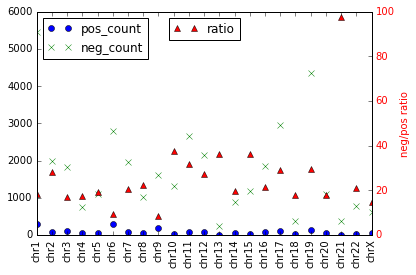

      Iter       Train Loss   Remaining Time 
         1           0.3815            4.52m
         2           0.3804            4.42m
         3           0.3792            4.47m
         4           0.3785            4.29m
         5           0.3772            4.36m
         6           0.3760            4.39m
         7           0.3747            4.34m
         8           0.3738            4.30m
         9           0.3727            4.29m
        10           0.3718            4.28m
        20           0.3635            4.30m
        30           0.3565            4.25m
        40           0.3501            4.22m
        50           0.3440            4.22m
        60           0.3385            4.24m
        70           0.3335            4.25m
        80           0.3289            4.23m
        90           0.3245            4.22m
       100           0.3205            4.22m
       200           0.2884            4.11m
       300           0.2648            4.01m
       40

/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


760 0.0
      Iter       Train Loss   Remaining Time 
         1           0.3815           41.74s
         2           0.3804           40.74s
         3           0.3792           41.02s
         4           0.3785           39.23s
         5           0.3772           39.72s
         6           0.3760           39.95s
         7           0.3747           39.48s
         8           0.3738           39.13s
         9           0.3727           38.96s
        10           0.3718           38.91s
        20           0.3635           38.51s
        30           0.3565           37.68s
        40           0.3501           37.03s
        50           0.3440           36.52s
        60           0.3385           35.92s
        70           0.3335           35.38s
        80           0.3289           34.81s
        90           0.3245           34.32s
       100           0.3205           33.78s
       200           0.2884           28.47s
       300           0.2648           23.27s
 

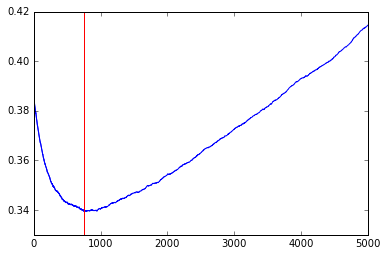

In [101]:
def train_estimator(train_data, train_label, val_data, val_label, n_estimators):
    from sklearn.ensemble import GradientBoostingClassifier
    params = {'n_estimators': n_estimators, 'max_depth': 5, 'max_features': 'log2',
              'learning_rate': 0.1, 'random_state': 3, 'verbose':1}
    estimator = GradientBoostingClassifier(**params)

    estimator.fit(train_data, train_label)
    
    x = np.arange(estimator.n_estimators)+1
    #oob_scores = -np.cumsum(estimator.oob_improvement_)
    score = np.zeros((estimator.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(estimator.staged_decision_function(val_data)):
        score[i] = estimator.loss_(val_label, y_pred)
    plt.plot(x, score, color='blue')
    plt.axvline(x=np.argmin(score)+1, color='r')
    #plt.plot(x, oob_scores, color='orange')
    print(np.argmin(score)+1, f1_score(val_label, estimator.predict(val_data)))
    return estimator, np.argmin(score)+1


In [7]:


cells = [ 'K562', 'GM12878','HeLa-S3', 'HUVEC', 'IMR90', 'NHEK']

K562
K562|chr15:
K562|chr22:
K562|chr16:
K562|chr4:
K562|chr11:
K562|chr19:
K562|chr8:
K562|chr12:
K562|chrX:
K562|chr2:
K562|chr13:
K562|chr3:
K562|chr6:
K562|chr18:
K562|chr7:
K562|chr5:
K562|chr21:
K562|chr9:
K562|chr17:
K562|chr10:
K562|chr1:
K562|chr14:
K562|chr20:


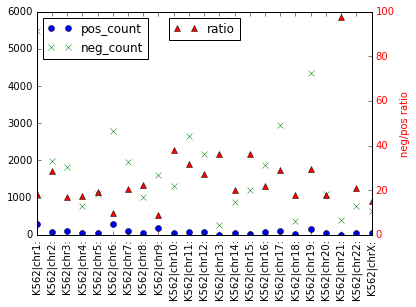

1
2
3
[('K562|chr16:', 'K562|chr7:', 'K562|chrX:'), ('K562|chr7:', 'K562|chr20:', 'K562|chr5:'), ('K562|chr16:', 'K562|chr7:', 'K562|chr18:'), ('K562|chr16:', 'K562|chr20:', 'K562|chr5:'), ('K562|chr15:', 'K562|chr20:', 'K562|chr3:'), ('K562|chr16:', 'K562|chr3:', 'K562|chr13:'), ('K562|chr12:', 'K562|chr3:', 'K562|chr4:'), ('K562|chr7:', 'K562|chr21:', 'K562|chr3:'), ('K562|chr7:', 'K562|chr14:', 'K562|chr20:'), ('K562|chr16:', 'K562|chr7:', 'K562|chr4:'), ('K562|chr15:', 'K562|chr3:', 'K562|chr5:'), ('K562|chr12:', 'K562|chr3:', 'K562|chrX:'), ('K562|chr7:', 'K562|chr14:', 'K562|chr5:'), ('K562|chr7:', 'K562|chr20:', 'K562|chr4:'), ('K562|chr8:', 'K562|chr7:', 'K562|chr20:'), ('K562|chr8:', 'K562|chr7:', 'K562|chr5:'), ('K562|chr10:', 'K562|chr20:', 'K562|chr3:'), ('K562|chr3:', 'K562|chr2:', 'K562|chrX:'), ('K562|chr3:', 'K562|chr2:', 'K562|chr4:'), ('K562|chr16:', 'K562|chr22:', 'K562|chr3:')]
GM12878
GM12878|chr4:
GM12878|chr1:
GM12878|chr6:
GM12878|chr7:
GM12878|chr14:
GM12878|ch

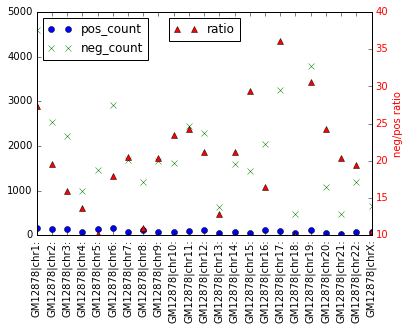

1
2
3
[('GM12878|chr11:', 'GM12878|chr22:', 'GM12878|chrX:'), ('GM12878|chr3:', 'GM12878|chr22:', 'GM12878|chr15:'), ('GM12878|chr20:', 'GM12878|chr13:', 'GM12878|chr2:'), ('GM12878|chr11:', 'GM12878|chr7:', 'GM12878|chr13:'), ('GM12878|chr20:', 'GM12878|chr16:', 'GM12878|chr14:'), ('GM12878|chr7:', 'GM12878|chr4:', 'GM12878|chr10:'), ('GM12878|chr11:', 'GM12878|chr14:', 'GM12878|chrX:'), ('GM12878|chr11:', 'GM12878|chr16:'), ('GM12878|chr7:', 'GM12878|chr9:', 'GM12878|chr22:'), ('GM12878|chr20:', 'GM12878|chr21:', 'GM12878|chr6:'), ('GM12878|chr11:', 'GM12878|chr3:'), ('GM12878|chr11:', 'GM12878|chr22:', 'GM12878|chr4:'), ('GM12878|chr9:', 'GM12878|chr21:', 'GM12878|chr12:'), ('GM12878|chr14:', 'GM12878|chr4:', 'GM12878|chr10:'), ('GM12878|chr11:', 'GM12878|chr14:', 'GM12878|chr4:'), ('GM12878|chr11:', 'GM12878|chr18:', 'GM12878|chr9:'), ('GM12878|chr12:', 'GM12878|chr4:', 'GM12878|chr10:'), ('GM12878|chr13:', 'GM12878|chr2:', 'GM12878|chr15:'), ('GM12878|chr18:', 'GM12878|chr2:', 'GM

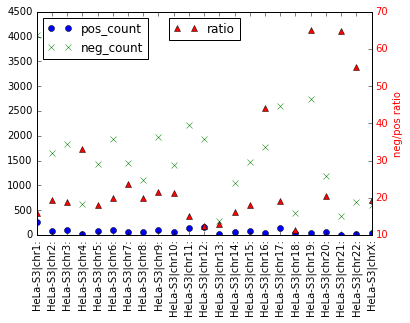

1
2
3
[('HeLa-S3|chr6:', 'HeLa-S3|chr10:', 'HeLa-S3|chr13:'), ('HeLa-S3|chr6:', 'HeLa-S3|chrX:', 'HeLa-S3|chr8:'), ('HeLa-S3|chr17:', 'HeLa-S3|chr10:'), ('HeLa-S3|chrX:', 'HeLa-S3|chr10:', 'HeLa-S3|chr2:'), ('HeLa-S3|chr4:', 'HeLa-S3|chr2:', 'HeLa-S3|chr3:'), ('HeLa-S3|chr6:', 'HeLa-S3|chrX:', 'HeLa-S3|chr10:'), ('HeLa-S3|chr14:', 'HeLa-S3|chr6:', 'HeLa-S3|chr4:'), ('HeLa-S3|chr6:', 'HeLa-S3|chr2:'), ('HeLa-S3|chr6:', 'HeLa-S3|chr18:', 'HeLa-S3|chr7:'), ('HeLa-S3|chr20:', 'HeLa-S3|chr4:', 'HeLa-S3|chr3:'), ('HeLa-S3|chr2:', 'HeLa-S3|chr9:'), ('HeLa-S3|chr15:', 'HeLa-S3|chr10:', 'HeLa-S3|chr20:'), ('HeLa-S3|chr6:', 'HeLa-S3|chrX:', 'HeLa-S3|chr20:'), ('HeLa-S3|chr21:', 'HeLa-S3|chr17:', 'HeLa-S3|chr18:'), ('HeLa-S3|chrX:', 'HeLa-S3|chr2:', 'HeLa-S3|chr9:'), ('HeLa-S3|chrX:', 'HeLa-S3|chr7:', 'HeLa-S3|chr3:'), ('HeLa-S3|chr6:', 'HeLa-S3|chr3:'), ('HeLa-S3|chrX:', 'HeLa-S3|chr8:', 'HeLa-S3|chr3:'), ('HeLa-S3|chrX:', 'HeLa-S3|chr8:', 'HeLa-S3|chr9:'), ('HeLa-S3|chr13:', 'HeLa-S3|chr7:', 'H

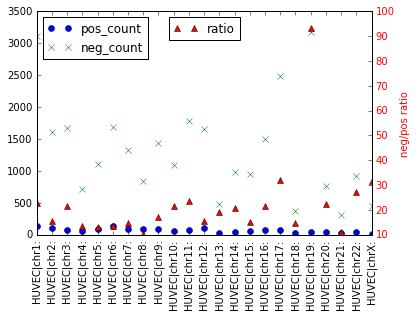

1
2
3
[('HUVEC|chrX:', 'HUVEC|chr11:', 'HUVEC|chr5:'), ('HUVEC|chr3:', 'HUVEC|chr22:', 'HUVEC|chr4:'), ('HUVEC|chr3:', 'HUVEC|chr21:', 'HUVEC|chr14:'), ('HUVEC|chr3:', 'HUVEC|chr21:', 'HUVEC|chr11:'), ('HUVEC|chr15:', 'HUVEC|chr3:', 'HUVEC|chr22:'), ('HUVEC|chr10:', 'HUVEC|chr22:', 'HUVEC|chr9:'), ('HUVEC|chrX:', 'HUVEC|chr11:', 'HUVEC|chr7:'), ('HUVEC|chr16:', 'HUVEC|chr22:', 'HUVEC|chr4:'), ('HUVEC|chr15:', 'HUVEC|chr13:', 'HUVEC|chr11:'), ('HUVEC|chr3:', 'HUVEC|chr9:'), ('HUVEC|chr20:', 'HUVEC|chr14:', 'HUVEC|chr9:'), ('HUVEC|chr10:', 'HUVEC|chr11:', 'HUVEC|chr4:'), ('HUVEC|chr2:', 'HUVEC|chr20:', 'HUVEC|chr22:'), ('HUVEC|chr16:', 'HUVEC|chr20:', 'HUVEC|chr4:'), ('HUVEC|chr15:', 'HUVEC|chr20:', 'HUVEC|chr11:'), ('HUVEC|chr16:', 'HUVEC|chr10:', 'HUVEC|chr4:'), ('HUVEC|chr18:', 'HUVEC|chr15:', 'HUVEC|chr11:'), ('HUVEC|chr16:', 'HUVEC|chr15:', 'HUVEC|chr20:'), ('HUVEC|chr21:', 'HUVEC|chr10:', 'HUVEC|chr11:'), ('HUVEC|chr10:', 'HUVEC|chr14:', 'HUVEC|chr9:')]
IMR90
IMR90|chr6:
IMR90|chr1

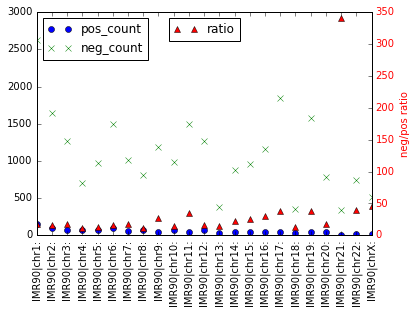

1
2
3
[('IMR90|chr12:', 'IMR90|chr7:', 'IMR90|chr21:'), ('IMR90|chr17:', 'IMR90|chr4:', 'IMR90|chr18:'), ('IMR90|chr15:', 'IMR90|chrX:', 'IMR90|chr5:'), ('IMR90|chr22:', 'IMR90|chr14:', 'IMR90|chr5:'), ('IMR90|chr9:', 'IMR90|chr13:', 'IMR90|chr7:'), ('IMR90|chrX:', 'IMR90|chr20:', 'IMR90|chr12:'), ('IMR90|chr15:', 'IMR90|chr3:', 'IMR90|chr18:'), ('IMR90|chr11:', 'IMR90|chr13:', 'IMR90|chr5:'), ('IMR90|chr11:', 'IMR90|chr18:', 'IMR90|chr10:'), ('IMR90|chr9:', 'IMR90|chr15:', 'IMR90|chr4:'), ('IMR90|chr16:', 'IMR90|chr4:', 'IMR90|chr14:'), ('IMR90|chr9:', 'IMR90|chr4:', 'IMR90|chr22:'), ('IMR90|chr13:', 'IMR90|chr16:', 'IMR90|chr12:'), ('IMR90|chr15:', 'IMR90|chr20:', 'IMR90|chr7:'), ('IMR90|chr8:', 'IMR90|chr19:', 'IMR90|chr18:'), ('IMR90|chr11:', 'IMR90|chr20:', 'IMR90|chr4:'), ('IMR90|chr11:', 'IMR90|chr4:', 'IMR90|chr18:'), ('IMR90|chr9:', 'IMR90|chr13:', 'IMR90|chr3:'), ('IMR90|chr16:', 'IMR90|chr3:', 'IMR90|chr18:'), ('IMR90|chr19:', 'IMR90|chr4:', 'IMR90|chr18:')]
NHEK
NHEK|chr2:


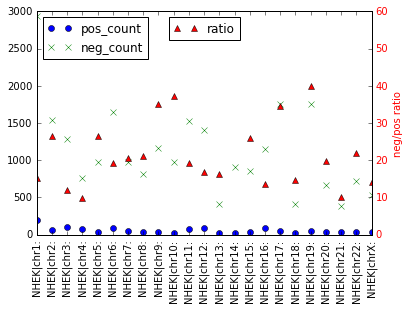

1
2
3
[('NHEK|chr9:', 'NHEK|chr16:', 'NHEK|chr13:'), ('NHEK|chr12:', 'NHEK|chr20:', 'NHEK|chr15:'), ('NHEK|chr19:', 'NHEK|chr3:'), ('NHEK|chr18:', 'NHEK|chr5:', 'NHEK|chr11:'), ('NHEK|chr13:', 'NHEK|chr22:', 'NHEK|chr11:'), ('NHEK|chr18:', 'NHEK|chr15:', 'NHEK|chr11:'), ('NHEK|chr7:', 'NHEK|chr2:', 'NHEK|chr21:'), ('NHEK|chr8:', 'NHEK|chr22:', 'NHEK|chr11:'), ('NHEK|chrX:', 'NHEK|chr5:', 'NHEK|chr11:'), ('NHEK|chr4:', 'NHEK|chr19:', 'NHEK|chr13:'), ('NHEK|chr7:', 'NHEK|chr13:', 'NHEK|chr11:'), ('NHEK|chr6:', 'NHEK|chr8:', 'NHEK|chr13:'), ('NHEK|chr6:', 'NHEK|chr13:', 'NHEK|chr15:'), ('NHEK|chr4:', 'NHEK|chr10:', 'NHEK|chr5:'), ('NHEK|chr18:', 'NHEK|chr22:', 'NHEK|chr11:'), ('NHEK|chr2:', 'NHEK|chr8:', 'NHEK|chr21:'), ('NHEK|chr6:', 'NHEK|chr22:', 'NHEK|chr20:'), ('NHEK|chr8:', 'NHEK|chr10:', 'NHEK|chr16:'), ('NHEK|chr12:', 'NHEK|chr14:', 'NHEK|chr21:'), ('NHEK|chr9:', 'NHEK|chr16:', 'NHEK|chr20:')]


In [66]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    all_scores = {}
    for cell in cells:
        all_scores[cell] = run_for_cell(cell)

In [138]:
import pickle
with open("all_scores.pickle", 'wb') as out:
    pickle.dump(all_scores, out)

In [12]:
import pickle
all_scores = pickle.load(open("all_scores.pickle", 'rb'))

In [36]:
#mean f1-scores of the chromosome-split performance at best iterations
for cell in cells:
    print(cell, np.mean([np.max(x[2][:,0]) for x in all_scores[cell][1]]))

K562 0.0140559359838
GM12878 0.0894980517882
HeLa-S3 0.0357890335033
HUVEC 0.0924314213712
IMR90 0.0674323606787
NHEK 0.0339336867212


In [13]:
def get_baseline(mode):
    a = [0]*10000 + [1] * 10000
    baselines = []
    for _ in range(1000):
        b_pos = np.random.rand(500) / 2 + 0.5
        b_neg = np.random.rand(10000) / 2

        b = np.concatenate((b_pos, b_neg), axis=0)
        np.random.shuffle(b)
        #b = np.random.rand(len(a))
        #b = np.ones(len(a))

        if mode == 'f1':
            baselines.append(f1_score(a,shuffle(a)))
        elif mode == 'accuracy':
            baselines.append(accuracy_score(a,shuffle(a)))
        elif mode == 'auprc':
            baselines.append(average_precision_score(a,b))
        elif mode == 'auroc':
            baselines.append(roc_auc_score(a,b))
        
    return np.mean(baselines)

f1_baseline = max(2/23, 1/21)
auprc_baseline = 1 / 21
auroc_baseline = 0.5
accuracy_baseline = max((20*20/21+1/21)/21, 0.5)
baselines = (f1_baseline, auprc_baseline, auroc_baseline, accuracy_baseline)
print(baselines)

(0.08695652173913043, 0.047619047619047616, 0.5, 0.909297052154195)


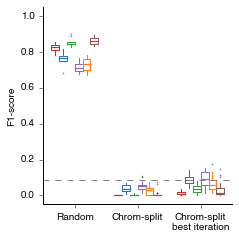

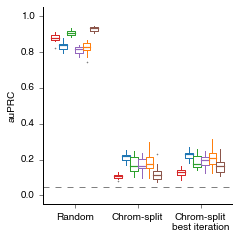

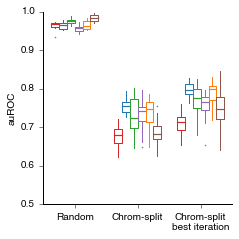

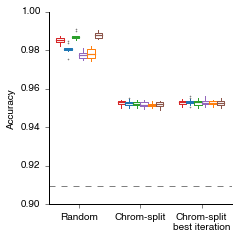

In [17]:

offsets = [-3, -2, -1, 0, 1, 2]
width = 0.125
names = ['F1-score', 'auPRC', 'auROC','Accuracy']
for i,name in enumerate(names):
    fig = plt.figure(figsize=(col1Width, col1Width))
    ax = fig.add_subplot(1,1,1)
    flierprops = dict(marker='+', color="#aaaaaa", markersize=2, alpha=0.5)
    all_boxes = []
    for idx, cell in enumerate(cells):
        offset = offsets[idx] * width + 0.5*width
        box = ax.boxplot([[x[2][-1,i] for x in all_scores[cell][0]],
                          [x[2][-1,i] for x in all_scores[cell][1]],
                          [np.max(x[2][:,i]) for x in all_scores[cell][1]]],
                    positions=[1+offset, 2+offset, 3+offset], widths=0.125,
                    notch=False, flierprops=flierprops)
        all_boxes.append(box)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Random', 'Chrom-split', 'Chrom-split\nbest iteration'])

    ax.set_xlim([0.5,3.5])
    if i == 2:
        ax.set_ylim([0.5, 1.0])
    elif i == 3:
        ax.set_ylim([0.9, 1.0])
    else:
        ax.set_ylim([-0.05, 1.05])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(y=baselines[i], linestyle='--', color='gray')
    ax.tick_params(axis='x', direction='out', top='off')
    ax.tick_params(axis='y', direction='out', right='off')
    for j in range(len(all_boxes)):
        box = all_boxes[j]
        curr_color = colors[j*2]
        for i in range(3):

            #box['boxes'][i].set_facecolor(curr_color)
            box['boxes'][i].set_color(curr_color)

            box['whiskers'][i * 2].set_color(curr_color)
            box['whiskers'][i * 2 + 1].set_color(curr_color)
            box['whiskers'][i * 2].set_linewidth(1)
            box['whiskers'][i * 2 + 1].set_linewidth(1)
            box['whiskers'][i * 2].set_linestyle('-')
            box['whiskers'][i * 2 + 1].set_linestyle('-')

            box['medians'][i].set_color(curr_color)
            box['medians'][i].set_linewidth(1.2)

            box['caps'][i * 2].set_color(curr_color)
            box['caps'][i * 2 + 1].set_color(curr_color)
        for c in box['caps']:
            c.set_linewidth(0)
    ax.set_ylabel(name)
    #ax.set_xlabel('')
    fig.tight_layout()
    fig.savefig("targetfinder_split_by_chrom_performance_{}.pdf".format(name.split('-')[0].lower()), dpi=600)
    fig.savefig("targetfinder_split_by_chrom_performance_{}.png".format(name.split('-')[0].lower()), dpi=600)

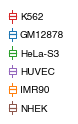

In [9]:
inch = 25.4
col1Width = 87 / inch
offsets = [-3, -2, -1, 0, 1, 2]
width = 0.1
fig = plt.figure(figsize=(col1Width/3.8, col1Width/2.2), frameon=False)
ax = fig.add_subplot(1,1,1)
flierprops = dict(marker='+', color="#aaaaaa", markersize=2, alpha=0.5)
all_boxes = []
for idx, cell in enumerate(cells):
    offset = offsets[idx] * width + 0.5*width
    box = ax.boxplot([[-2*idx+0.7,-idx*2,-2*idx-0.7]],
                positions=[1,], widths=width,
                notch=False, flierprops=flierprops)
    ax.text(1+width, -idx*2-0.4, cell)
    all_boxes.append(box)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_xticklabels(['Random', '2-chrom', '2-chrom\nbest iteration'])

ax.set_xlim([0.93, 1.78])
ax.set_ylim([-11, 1.])


ax.tick_params(axis='x', direction='out', top='off', bottom='off')
ax.tick_params(axis='y', direction='out', right='off', left='off')
for j in range(len(all_boxes)):
    box = all_boxes[j]
    curr_color = colors[j*2]
    for i in range(1):
        
        #box['boxes'][i].set_facecolor(curr_color)
        box['boxes'][i].set_color(curr_color)

        box['whiskers'][i * 2].set_color(curr_color)
        box['whiskers'][i * 2 + 1].set_color(curr_color)
        box['whiskers'][i * 2].set_linewidth(1)
        box['whiskers'][i * 2 + 1].set_linewidth(1)
        box['whiskers'][i * 2].set_linestyle('-')
        box['whiskers'][i * 2 + 1].set_linestyle('-')

        box['medians'][i].set_color(curr_color)
        box['medians'][i].set_linewidth(1.2)

        box['caps'][i * 2].set_color(curr_color)
        box['caps'][i * 2 + 1].set_color(curr_color)
    for c in box['caps']:
        c.set_linewidth(0)
ax.axis('off')
#ax.set_ylabel("F1-score")
#ax.set_xlabel('')
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99,
                wspace=None, hspace=None)
#fig.tight_layout()

fig.savefig("targetfinder_cell_boxplot_legend.pdf", dpi=600)
fig.savefig("targetfinder_cell_boxplot_legend.png", dpi=600)

In [157]:
for i in range(4):
    for c in cells:
        print(c + "\t" + "\t".join(map(str, [x[2][-1,i] for x in all_scores[c][0]])))
    print()

K562	0.809248554913	0.794366197183	0.85393258427	0.852272727273	0.830945558739	0.781341107872	0.826815642458	0.813559322034	0.838888888889	0.839436619718
GM12878	0.809523809524	0.769230769231	0.78125	0.749295774648	0.75208913649	0.816438356164	0.775067750678	0.765027322404	0.750684931507	0.682080924855
HeLa-S3	0.849230769231	0.84076433121	0.847133757962	0.825806451613	0.843137254902	0.898461538462	0.844036697248	0.85626911315	0.886850152905	0.84076433121
HUVEC	0.694560669456	0.674796747967	0.715384615385	0.737254901961	0.768060836502	0.737254901961	0.710204081633	0.710204081633	0.680497925311	0.693227091633
IMR90	0.783410138249	0.695238095238	0.733944954128	0.673076923077	0.707547169811	0.692682926829	0.785388127854	0.767772511848	0.736363636364	0.731707317073
NHEK	0.878661087866	0.882352941176	0.841201716738	0.857142857143	0.891666666667	0.833333333333	0.870292887029	0.866666666667	0.854700854701	0.839826839827

K562	0.865672392178	0.86074277968	0.901383202436	0.911527289153	0.8967173

In [155]:
for c in cells:
    print(c)
    for x in all_scores[c][1]:
        print(x[0], 
              x[1][-1,0], x[2][-1,0], x[1][np.argmax(x[2][:,0]),0], np.max(x[2][:,0]), np.argmax(x[2][:,0]), 
              x[1][-1,1], x[2][-1,1], x[1][np.argmax(x[2][:,1]),1], np.max(x[2][:,1]), np.argmax(x[2][:,0]), 
              x[1][-1,2], x[2][-1,2], x[1][np.argmax(x[2][:,2]),2], np.max(x[2][:,2]), np.argmax(x[2][:,0]), 
              x[1][-1,3], x[2][-1,3], x[1][np.argmax(x[2][:,3]),3], np.max(x[2][:,3]), np.argmax(x[2][:,0]), 
              sep='\t')

K562
('K562|chr16:', 'K562|chr7:', 'K562|chrX:')	1.0	0.0	0.591763294682	0.0177777777778	107	1.0	0.107277376429	0.897251627262	0.150214090791	107	1.0	0.684598863655	0.981903415715	0.75264346963	107	1.0	0.952421591636	0.972247893449	0.952848303819	107
('K562|chr7:', 'K562|chr20:', 'K562|chr5:')	1.0	0.0	0.391640163562	0.0185185185185	59	1.0	0.113958560071	0.760048674967	0.135050840677	59	1.0	0.672763716961	0.929428128707	0.684641692203	59	1.0	0.951141552511	0.963905437097	0.951598173516	59
('K562|chr16:', 'K562|chr7:', 'K562|chr18:')	1.0	0.0	0.561643835616	0.0193236714976	101	1.0	0.103876301162	0.792671811857	0.160722557363	101	1.0	0.712755995181	0.971450210956	0.748945902195	101	1.0	0.954195011338	0.953030997923	0.954421768707	101
('K562|chr16:', 'K562|chr20:', 'K562|chr5:')	1.0	0.0	0.121822033898	0.00970873786408	14	1.0	0.11165996611	1.0	0.115424234378	14	1.0	0.649805298053	0.999769807115	0.673787537875	14	1.0	0.951990632319	0.955438492757	0.952224824356	14
('K562|chr15:', 'K562|chr20:'

In [20]:

nonpredictors = ['enhancer_chrom', 'enhancer_start', 'enhancer_end', 'enhancer_name', 'promoter_name',
                     'promoter_chrom', 'promoter_start', 'promoter_end', 
                     'window_chrom', 'window_start', 'window_end',
                     'active_promoters_in_window', 'interactions_in_window', 
                     'enhancer_distance_to_promoter', 'bin', 'label']

all_means = []
for idx, cell in enumerate(cells):
    training_df = pd.read_hdf('{}/output-epw/training.h5'.format(cell), 
                              'training').set_index(['window_name'])
    predictors_df = training_df.drop(nonpredictors, axis = 1)
    all_means.append((predictors_df>0).mean())
    


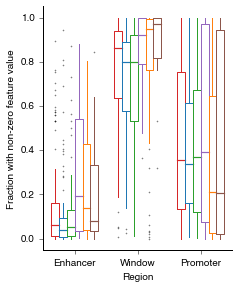

In [21]:
inch = 25.4
col1Width = 87 / inch
offsets = [-3, -2, -1, 0, 1, 2]
width = 0.125
fig = plt.figure(figsize=(col1Width, col1Width*1.2))
ax = fig.add_subplot(1,1,1)
flierprops = dict(marker='+', color="#aaaaaa", markersize=2, alpha=0.5)
all_boxes = []
for idx, percent_with_data in enumerate(all_means):
    offset = offsets[idx] * width + 0.5*width
    box = ax.boxplot([percent_with_data[[i for i in percent_with_data.index if i.endswith('(enhancer)')]],
                 percent_with_data[[i for i in percent_with_data.index if i.endswith('(window)')]],
                 percent_with_data[[i for i in percent_with_data.index if i.endswith('(promoter)')]]],
                positions=[1+offset, 2+offset, 3+offset], widths=0.125,
                notch=False, flierprops=flierprops)
    all_boxes.append(box)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Enhancer', 'Window', 'Promoter'])

ax.set_xlim([0.5,3.5])
ax.set_ylim([-0.05, 1.05])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', direction='out', top='off')
ax.tick_params(axis='y', direction='out', right='off')
for j in range(len(all_boxes)):
    box = all_boxes[j]
    curr_color = colors[j*2]
    for i in range(3):
        
        #box['boxes'][i].set_facecolor(curr_color)
        box['boxes'][i].set_color(curr_color)

        box['whiskers'][i * 2].set_color(curr_color)
        box['whiskers'][i * 2 + 1].set_color(curr_color)
        box['whiskers'][i * 2].set_linewidth(1)
        box['whiskers'][i * 2 + 1].set_linewidth(1)
        box['whiskers'][i * 2].set_linestyle('-')
        box['whiskers'][i * 2 + 1].set_linestyle('-')

        box['medians'][i].set_color(curr_color)
        box['medians'][i].set_linewidth(1.2)

        box['caps'][i * 2].set_color(curr_color)
        box['caps'][i * 2 + 1].set_color(curr_color)
    for c in box['caps']:
        c.set_linewidth(0)
ax.set_ylabel("Fraction with non-zero feature value")
ax.set_xlabel('Region')
fig.tight_layout()
fig.savefig("targetfinder_fraction_with_non_zero_feature_value.pdf", dpi=600)
fig.savefig("targetfinder_fraction_with_non_zero_feature_value.png", dpi=600)

In [5]:
def get_error_for_cell(cell, frac):
    print(cell, frac)
    training_df = pd.read_hdf('{}/output-epw/training.h5'.format(cell), 
                                  'training').set_index('window_name')
    predictors_df = training_df.sort_values(['window_chrom', 
                                         'window_start', 
                                         'window_end']).ix[:, [n for n in training_df.columns if n.endswith('(window)')]]

    pos_predictors_df = predictors_df.loc[training_df.loc[:, 'label']==1, :]
    neg_predictors_df = predictors_df.loc[training_df.loc[:, 'label']==0, :]

    pairs = []
    pairs_index = []
    with open("{}/output-epw/overlap_pos_pos_0.{}_pairs.txt".format(cell, frac)) as f:
        pos_indexes = pos_predictors_df.index
        for r in f:
            pairs.append(r.strip().split())
            pairs_index.append([pos_predictors_df.index.get_loc(pairs[-1][0]), 
                                pos_predictors_df.index.get_loc(pairs[-1][1])])
    temp = sorted(np.random.choice(len(pos_predictors_df)*(len(pos_predictors_df)-1)//2,  len(pairs), replace=False))
    ticker = 0
    pointer = 0
    random_pairs = []
    for i in range(len(pos_predictors_df)-1):
        for j in range(i+1, len(pos_predictors_df)):
            if ticker == temp[pointer]:
                random_pairs.append([i,j])
                pointer += 1
            if pointer >= len(temp):
                break
            ticker += 1
        if pointer >= len(temp):
            break
    print(len(random_pairs), len(pairs))

    from sklearn.metrics import mean_absolute_error
    pair_errors = [mean_absolute_error(pos_predictors_df.iloc[p[0],:], 
                                       pos_predictors_df.iloc[p[1],:]) for p in pairs_index]
    random_pair_errors = [mean_absolute_error(pos_predictors_df.iloc[p[0],:], 
                                              pos_predictors_df.iloc[p[1],:]) for p in random_pairs]
    return pair_errors, random_pair_errors

In [8]:
all_errors = {}
for cell in cells:
    all_errors[cell] = []
    for i in list(range(1, 10)) + [99]:
        all_errors[cell].append(get_error_for_cell(cell, i))
        
import pickle
with open("all_errors.pickle", 'wb') as out:
    pickle.dump(all_errors, out)

K562 1
10887 10887
K562 2
10455 10455
K562 3
10094 10094
K562 4
9699 9699
K562 5
8523 8523
K562 6
7309 7309
K562 7
7152 7152
K562 8
6855 6855
K562 9
6416 6416
K562 99
2145 2145
GM12878 1
5721 5721
GM12878 2
5328 5328
GM12878 3
4935 4935
GM12878 4
4583 4583
GM12878 5
4082 4082
GM12878 6
3796 3796
GM12878 7
3517 3517
GM12878 8
3199 3199
GM12878 9
3028 3028
GM12878 99
1758 1758
HeLa-S3 1
6818 6818
HeLa-S3 2
6782 6782
HeLa-S3 3
6691 6691
HeLa-S3 4
6454 6454
HeLa-S3 5
6110 6110
HeLa-S3 6
5945 5945
HeLa-S3 7
5823 5823
HeLa-S3 8
5777 5777
HeLa-S3 9
5370 5370
HeLa-S3 99
1463 1463
HUVEC 1
3891 3891
HUVEC 2
3831 3831
HUVEC 3
3659 3659
HUVEC 4
3412 3412
HUVEC 5
3213 3213
HUVEC 6
2933 2933
HUVEC 7
2758 2758
HUVEC 8
2606 2606
HUVEC 9
2395 2395
HUVEC 99
778 778
IMR90 1
2847 2847
IMR90 2
2758 2758
IMR90 3
2533 2533
IMR90 4
2405 2405
IMR90 5
2297 2297
IMR90 6
2158 2158
IMR90 7
2044 2044
IMR90 8
1894 1894
IMR90 9
1838 1838
IMR90 99
896 896
NHEK 1
4282 4282
NHEK 2
4280 4280
NHEK 3
4277 4277
NHEK 4
4091 

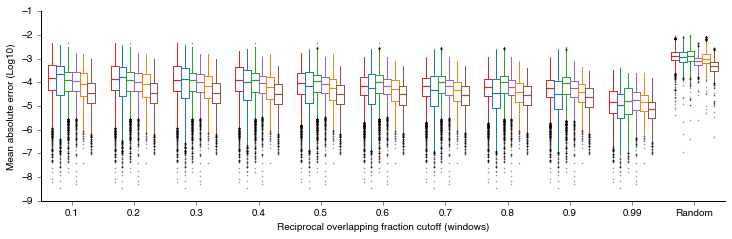

In [76]:

inch = 25.4
col1Width = 87 / inch
offsets = [-3, -2, -1, 0, 1, 2]
width = 0.125
fig = plt.figure(figsize=(col1Width*3, col1Width))
ax = fig.add_subplot(1,1,1)
all_boxes = []
flierprops = dict(marker='+', color="#aaaaaa", markersize=2, alpha=0.4)
for idx, cell in enumerate(cells):
    offset = offsets[idx] * width + 0.5*width
    box = ax.boxplot([np.log10(x[0]) for x in all_errors[cell]] 
                      +[np.log10(all_errors[cell][0][1])],
                    positions=np.arange(1,12) + offset, widths=0.125,
                    notch=False, flierprops=flierprops)
    all_boxes.append(box)
ax.set_xticks(np.arange(1,12))
ax.set_xticklabels(['0.{}'.format(x) for x in list(range(1,10)) + [99]] + ['Random'])

ax.set_xlim([0.5,11.5])
#ax.set_ylim([-7, -1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', direction='out', top='off')
ax.tick_params(axis='y', direction='out', right='off')


for j in range(len(all_boxes)):
    box = all_boxes[j]
    curr_color = colors[j*2]
    for i in range(11):
        
        #box['boxes'][i].set_facecolor(curr_color)
        box['boxes'][i].set_color(curr_color)

        box['whiskers'][i * 2].set_color(curr_color)
        box['whiskers'][i * 2 + 1].set_color(curr_color)
        box['whiskers'][i * 2].set_linewidth(1)
        box['whiskers'][i * 2 + 1].set_linewidth(1)
        box['whiskers'][i * 2].set_linestyle('-')
        box['whiskers'][i * 2 + 1].set_linestyle('-')

        box['medians'][i].set_color(curr_color)
        box['medians'][i].set_linewidth(1.2)

        box['caps'][i * 2].set_color(curr_color)
        box['caps'][i * 2 + 1].set_color(curr_color)
    for c in box['caps']:
        c.set_linewidth(0)
ax.set_ylabel("Mean absolute error (Log10)")
ax.set_xlabel("Reciprocal overlapping fraction cutoff (windows)")
fig.tight_layout()
fig.savefig("targetfinder_mean_absolute_error_between_pos_pairs_frac_all.pdf", dpi=600)
fig.savefig("targetfinder_mean_absolute_error_between_pos_pairs_frac_all.png", dpi=600)

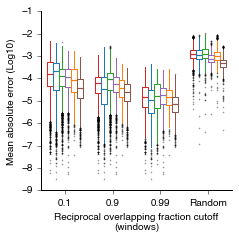

In [77]:

inch = 25.4
col1Width = 87 / inch
offsets = [-3, -2, -1, 0, 1, 2]
width = 0.125
fig = plt.figure(figsize=(col1Width, col1Width))
ax = fig.add_subplot(1,1,1)
all_boxes = []
flierprops = dict(marker='+', color="#aaaaaa", markersize=2, alpha=0.4)
for idx, cell in enumerate(cells):
    offset = offsets[idx] * width + 0.5*width
    box = ax.boxplot([np.log10(x[0]) for x in [all_errors[cell][i] for i in [0,-2,-1]]] 
                      +[np.log10(all_errors[cell][0][1])],
                    positions=np.arange(1,5) + offset, widths=0.125,
                    notch=False, flierprops=flierprops)
    all_boxes.append(box)
ax.set_xticks(np.arange(1,12))
ax.set_xticklabels(['0.{}'.format(x) for x in [1,9,99]] + ['Random'])

ax.set_xlim([0.5,4.5])
#ax.set_ylim([-7, -1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', direction='out', top='off')
ax.tick_params(axis='y', direction='out', right='off')


for j in range(len(all_boxes)):
    box = all_boxes[j]
    curr_color = colors[j*2]
    for i in range(4):
        
        #box['boxes'][i].set_facecolor(curr_color)
        box['boxes'][i].set_color(curr_color)

        box['whiskers'][i * 2].set_color(curr_color)
        box['whiskers'][i * 2 + 1].set_color(curr_color)
        box['whiskers'][i * 2].set_linewidth(1)
        box['whiskers'][i * 2 + 1].set_linewidth(1)
        box['whiskers'][i * 2].set_linestyle('-')
        box['whiskers'][i * 2 + 1].set_linestyle('-')

        box['medians'][i].set_color(curr_color)
        box['medians'][i].set_linewidth(1.2)

        box['caps'][i * 2].set_color(curr_color)
        box['caps'][i * 2 + 1].set_color(curr_color)
    for c in box['caps']:
        c.set_linewidth(0)
ax.set_ylabel("Mean absolute error (Log10)")
ax.set_xlabel("Reciprocal overlapping fraction cutoff\n(windows)")
fig.tight_layout()
fig.savefig("targetfinder_mean_absolute_error_between_pos_pairs_frac.pdf", dpi=600)
fig.savefig("targetfinder_mean_absolute_error_between_pos_pairs_frac.png", dpi=600)

In [42]:
for cell in cells:
    print(cell, end='\t')
    print('\t'.join(map(str, [np.median(all_errors[cell][i][0]) for i in range(len(all_errors[cell]))] + [np.median(all_errors[cell][0][1])])))

K562	0.000156717452532	0.000141424668028	0.000130670067904	0.000120069871707	9.1529127489e-05	7.09670234785e-05	6.91825363365e-05	6.59552467655e-05	6.01129036994e-05	1.50561304095e-05	0.00125853736205
GM12878	0.000219925525514	0.000176261404475	0.000134085113413	0.000106391881344	7.11787492758e-05	5.80095694903e-05	4.69874096802e-05	3.64862198373e-05	3.28084347386e-05	1.06330392927e-05	0.00116672657047
HeLa-S3	0.000129833585814	0.000128771730162	0.000126135221622	0.000120759563254	0.000112684076009	0.000107597520306	0.000104640554604	0.000102952699378	9.1373306495e-05	1.65873376314e-05	0.00124408007229
HUVEC	0.000110759199772	0.000108199727714	0.000101949061629	9.38341874107e-05	8.45682698097e-05	7.31249231747e-05	6.8673017391e-05	6.42120520648e-05	5.83808022179e-05	1.87836304266e-05	0.00077820074768
IMR90	8.9050799321e-05	8.32479603015e-05	6.81527898882e-05	6.1714670413e-05	5.68652900356e-05	5.10347329154e-05	4.71302550145e-05	4.05200405963e-05	3.85069678071e-05	1.43532345635e-05	0.00

In [43]:
for cell in cells:
    print(cell, end='\t')
    print('\t'.join(map(str, [np.mean(all_errors[cell][i][0]) for i in range(len(all_errors[cell]))] + [np.mean(all_errors[cell][0][1])])))

K562	0.000347224635014	0.000303550625298	0.000276446229687	0.00025646456989	0.000194541820136	0.000128422410577	0.000123660485917	0.000106380739821	8.86136536296e-05	2.75747943075e-05	0.00156444151806
GM12878	0.000356345625862	0.000296060017854	0.000258002580274	0.000220215764543	0.000174406658398	0.000151359699071	0.000135175664947	0.000112132065265	9.55490606965e-05	2.5258693049e-05	0.00148505907863
HeLa-S3	0.000219625819511	0.000216613973086	0.000206133814173	0.000193517148643	0.000167592179524	0.000153987494953	0.000147500035205	0.000146150042978	0.000126681658581	3.62002026548e-05	0.00172259616154
HUVEC	0.000192890119406	0.000185363278912	0.000164138306101	0.000141016853193	0.000126687589014	0.000115274927285	0.000105048464739	0.000101992517375	8.83021855939e-05	2.83958353964e-05	0.000899901697346
IMR90	0.000193278124862	0.000175429242799	0.000153383796902	0.000130439372997	0.000119956020669	0.000102650715902	9.13069946771e-05	6.75026606425e-05	6.36405188072e-05	2.29165884547e-05	

In [8]:
print(train_rows.shape, val_rows.shape)
print(sum(train_labels==1), sum(val_labels==1))
print(sum(train_labels==0)*1.0/sum(train_labels==1), sum(val_labels==0)*1.0/sum(val_labels==1))

(39276, 408) (2201, 408)
1770 207
21.1898305085 9.63285024155


In [61]:
## Now considers the overlap between TargetFinder windows, with increasing overlapping fraction

overlap_data_frac_pn = pd.read_csv('overlap_pos_neg.txt', sep=' ', names=['a_count', 'b_count', 'cell', 
                                                                       '1bp', '0.1', '0.2', '0.3', '0.4',
                                                                       '0.5', '0.6', '0.7', '0.8', '0.9', '0.99'])
overlap_data_frac_pn = overlap_data_frac_pn.set_index('cell')

overlap_data_frac_pp = pd.read_csv('overlap_pos_pos.txt', sep=' ', names=['a_count', 'b_count', 'cell', 
                                                                       '1bp', '0.1', '0.2', '0.3', '0.4',
                                                                       '0.5', '0.6', '0.7', '0.8', '0.9', '0.99'])
overlap_data_frac_pp = overlap_data_frac_pp.set_index('cell')


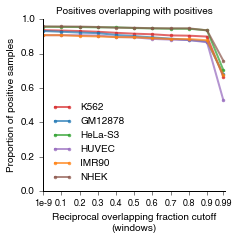

In [72]:
fig = plt.figure(figsize=(col1Width, col1Width))
ax = fig.add_subplot(111)
for i,cell in enumerate(cells):
    ax.plot([1e-9,] + list(np.arange(0.1, 0.99, 0.1)) + [0.99], 
             (overlap_data_frac_pp.ix[cell, 2:] / overlap_data_frac_pp.ix[cell,0]).values,
             color=colors[i*2], label=cell, linewidth=2, alpha=0.7, marker='.')

#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.set_xticks([1e-9,] + list(np.arange(0.1, 0.99, 0.1)) + [0.99])
ax.set_xticklabels(['1e-9'] + list(np.arange(0.1, 0.99, 0.1)) + [0.99], fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', top='off', direction='out')
ax.tick_params(axis='y', right='off', direction='out')
ax.set_title('Positives overlapping with positives', fontsize=10)
ax.set_ylim([0,1])
# Put a legend to the right of the current axis
ax.legend(loc='lower left', frameon=False, fontsize=10)
ax.set_xlabel('Reciprocal overlapping fraction cutoff\n(windows)', fontsize=10)
ax.set_ylabel('Proportion of positive samples', fontsize=10)
fig.tight_layout()
fig.savefig("targetfinder_fraction_change_with_increasing_overlapping.pdf", dpi=600)
fig.savefig("targetfinder_fraction_change_with_increasing_overlapping.png", dpi=600)

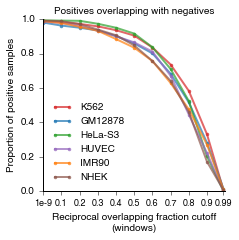

In [71]:
fig = plt.figure(figsize=(col1Width, col1Width))
ax = fig.add_subplot(111)

for i,cell in enumerate(cells):
    ax.plot([1e-9,] + list(np.arange(0.1, 0.99, 0.1)) + [0.99], 
             (overlap_data_frac_pn.ix[cell, 2:] / overlap_data_frac_pn.ix[cell,0]).values,
             color=colors[i*2], linewidth=2, alpha=0.7, marker='.', label=cell)
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.set_xticks([1e-9,] + list(np.arange(0.1, 0.99, 0.1)) + [0.99])
ax.set_xticklabels(['1e-9'] + list(np.arange(0.1, 0.99, 0.1)) + [0.99], fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', top='off', direction='out')
ax.tick_params(axis='y', right='off', direction='out')
ax.set_title('Positives overlapping with negatives', fontsize=10)

# Put a legend to the right of the current axis
ax.legend(loc='lower left', frameon=False, fontsize=10)
ax.set_xlabel('Reciprocal overlapping fraction cutoff\n(windows)', fontsize=10)
ax.set_ylabel('Proportion of positive samples', fontsize=10)
fig.tight_layout()
fig.savefig("targetfinder_fraction_change_with_increasing_overlapping_with_neg.pdf", dpi=600)
fig.savefig("targetfinder_fraction_change_with_increasing_overlapping_with_neg.png", dpi=600)